# Reverse MNIST

## Preliminaries

In [261]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

## Load MNIST DATA

In [307]:
howmany = -1 #50
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:howmany]).float().to(device), torch.tensor(train[1][:howmany]).float().to(device)]

## Create Network

In [310]:
# Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=784))  # 1 Input
net.Connect(0,1)
# Input layer is one-hot
net.layers[0].sigma = Layer.softmax
net.layers[0].sigma_p = Layer.softmax_p
# Top vector reconstructed image, [0, 1]
net.layers[1].sigma = Layer.logistic
net.layers[1].sigma_p = Layer.logistic_p

net.SetTau(0.04)

In [287]:
net.layers[0].Probe(True)
net.layers[1].Probe(True)

## Train the Network

In [311]:
# Train in reverse direction: one-hot -> reconstructed image
epochs = 10
T = 3.
dt = 0.01
start_time = time.time()
batch_size = 100
net.learning_tau = torch.tensor(batch_size).float().to(device) * 5.
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = NN.MakeBatches(train[1], train[0], batch_size=batch_size)
    for x in batches:
        #net.Reset()
        net.Infer(T, x[0], x[1], dt=dt)
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

Total time: 1431.1544585227966


In [312]:
net.connections[0].W

tensor([[ 7.1887e-02,  4.1694e-02,  3.4956e-02,  ...,  3.8796e-02,
          5.2357e-02,  4.5017e-02],
        [ 6.0329e-02,  3.9612e-02,  3.2366e-02,  ...,  4.9484e-02,
          5.5642e-02,  5.5912e-02],
        [-1.1934e-02, -2.6679e-02, -2.2368e-02,  ..., -1.3010e-02,
         -1.9315e-02, -2.1777e-02],
        ...,
        [-2.4175e-02, -3.9349e-02, -3.9757e-02,  ..., -4.5676e-02,
         -3.5950e-02, -4.4775e-02],
        [-1.9169e-02, -1.5776e-02, -1.6090e-02,  ..., -1.5669e-02,
         -1.4056e-02, -2.3180e-03],
        [-2.5370e-03, -5.9846e-03,  1.3149e-02,  ..., -4.7618e-03,
         -1.0428e-02, -2.4019e-02]], device='cuda:0')

## Probe the Model

In [313]:
z = net.Predict(10., train[1][0], dt=0.01)

In [314]:
plt.plot(net.t_history, np.array(net.layers[1].v_history)[:,200:300]);

IndexError: too many indices for array

## Save the Model

In [315]:
net.Save('MNIST reversed.npy')

## Test the Network

tensor([ 0.1463,  0.0790,  0.0497,  0.0784,  0.0228, -0.0949, -0.1570,
         0.8602, -0.1136,  0.1532], device='cuda:0')


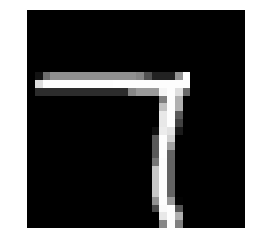

In [366]:
p = 147 #147 or 35   for 2s
p = 141 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.Reset()
net.SetTau(0.04)
z = net.Generate(3., test[0][p])
y = net.layers[1].sigma(z)
print(z)

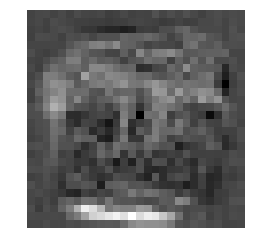

In [367]:
net.Reset()
z = net.Predict(3., test[1][p])
plt.imshow(np.reshape(z,[28, 28]), cmap='gray'); plt.axis('off');

In [351]:
indata = test[0][200:300]
outdata = test[1][200:300]
x = net.Generate(5., indata)

In [359]:
z = np.array(deepcopy(x))
for idx, blah in enumerate(x):
    z[idx,:] = NN.OneHot(blah)

In [362]:
err = np.sum(np.abs(z-outdata))/2.
print('Accuracy = '+str((len(z)-err)/len(z)*100.)+'%')

Accuracy = 85.0%


In [363]:
z-outdata

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [334]:
NN.OneHot(blah)

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [333]:
z[-1,:]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0')